In [2]:
!pip install pandas_ta
!pip install tf_agents[reverb]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=9fb956894f3af37a3955f45d89ac0424c06854b37b75c7c691caf7d116e8ddd4
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 44.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import reverb
import os
import tensorflow as tf
from collections import deque
import string
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics import py_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
import random

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.utils.common import Checkpointer
from tf_agents.policies import policy_saver

In [5]:
num_iterations = 20000000

initial_collect_steps = 100
collect_steps_per_iteration =   1
replay_buffer_max_length = 500000

batch_size = 64
learning_rate = 1e-3
log_interval = 1000

num_eval_episodes = 3
eval_interval = log_interval*10

In [6]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [7]:
def sharpe_ratio(returns):
    if returns.size < 2:
        return 0

    # Calculate the average returns and standard deviation
    avg_returns = np.mean(returns)
    std_dev = np.std(returns)

    # Calculate the Sharpe ratio
    sharpe = avg_returns / std_dev

    return sharpe

In [8]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


In [9]:
RSI = ta.rsi(close,14,scalar=1)
AROON = ta.aroon(high,low,14,scalar = 1)
AROON_UP = AROON['AROOND_14']
AROON_DOWN = AROON['AROONU_14']
CCI = ta.cci(high,low,close,14)
CCI = CCI.multiply(.001)
CCI = CCI.add(.5)
RVI = ta.rvi(close,high,low,14,scalar=1)
CHANGE = get_relative_change(close,"Change")
INDICATORS = pd.concat([CHANGE,RSI,AROON_UP,AROON_DOWN,CCI,RVI],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()

change = INDICATORS.pop('Change')
INDICATORS.pop('index')

INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev
np.set_printoptions(suppress=True)
print(change)

[-1.99453945  1.27757318 -0.7972413  ...  0.36195025 -0.31656675
 -0.04524129]


In [10]:
print(INDICATORS)

[[0.38187407 1.         0.71428571 0.39334634 0.85330187]
 [0.52438576 0.92857143 0.64285714 0.42260631 0.87272338]
 [0.45394255 0.85714286 0.57142857 0.38867102 0.75057577]
 ...
 [0.63073968 0.42857143 0.85714286 0.63507997 0.67330809]
 [0.60441535 0.35714286 0.78571429 0.61566583 0.57482093]
 [0.60055924 0.28571429 0.71428571 0.59201605 0.48856795]]


(5400.0, 5500.0)

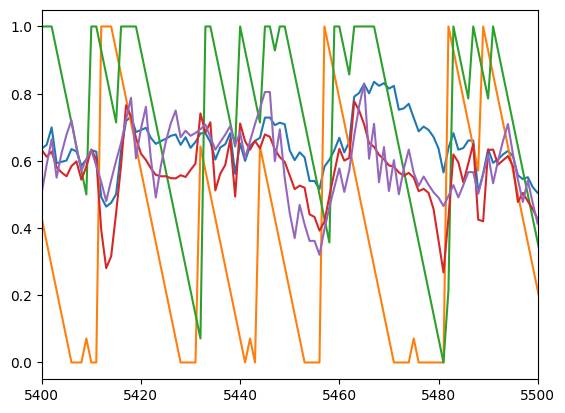

In [11]:
plt.plot(INDICATORS)
plt.xlim(5400,5500)
#print(INDICATORS)

In [12]:
max_ep_len = 500
min_range = 10000
max_range = 10001

In [29]:
class TradingEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int64, minimum=0, maximum=3, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(9,), dtype=np.float32, minimum=-100, maximum=100, name='observation')

        self._init_val = random.randint(min_range,max_range)
        self._trade_info = np.array([0, 0, 0, 0], dtype=np.float32)
        self._state = np.append(INDICATORS[self._init_val], (0, 0 , 0, 0))
        self._episode_ended = False
        self._count = self._init_val+1
        self._returns = np.array([])



    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):

        self._init_val = random.randint(min_range,max_range)
        self._trade_info = np.array([0, 0, 0, 0], dtype=np.float32)
        self._state = np.append(INDICATORS[self._init_val], (0, 0 , 0, 0))
        self._episode_ended = False
        self._count = self._init_val+1
        self._returns = np.array([])




        return ts.restart(np.array(self._state, dtype=np.float32))

    def _step(self, action):

        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        penelty = 0
        cash_out_val = 0
        if cash_out and self._trade_info[0] == 0:
            penelty = -10
        elif (buy or sell or cash_out):
            cash_out_val = self._trade_info[0]-.1

            if cash_out_val != 0:
                self._returns = np.append(self._returns,cash_out_val)

            if buy:
              self._trade_info[1] = 1
            elif sell:
              self._trade_info[1] = -1
            else:
              self._trade_info[1] = 0

            self._trade_info[0] = self._trade_info[1]*change[self._count]
            self._trade_info[2] = 0
            self._trade_info[3] = self._trade_info[0]

        else:
            self._trade_info[0] += self._trade_info[1]*change[self._count]
            self._trade_info[2] += .05
            self._trade_info[3] = self._trade_info[0] if self._trade_info[0]>self._trade_info[3] else self._trade_info[3]


        #add trade to returns array
        if cash_out_val != 0:
            self._returns = np.append(self._returns,cash_out_val)

        #update state
        self._state = np.append(INDICATORS[self._count], (self._trade_info), axis=0)

        if self._count >= (self._init_val + max_ep_len):
            self._episode_ended = True

        self._count += 1

        if self._episode_ended:
            reward = np.sum(self._returns)
            return ts.termination(np.array(self._state, dtype=np.float32), reward=reward)
        else:
            reward = cash_out_val+penelty if cash_out_val>0 else penelty
            return ts.transition(
                np.array(self._state, dtype=np.float32), reward=reward, discount=.95)

In [30]:
env = TradingEnv()

utils.validate_py_environment(env, episodes=2)

time_step = env.reset()
np.set_printoptions(linewidth=np.inf)
while not time_step.is_last():
    # Access the current observation
    observation = time_step.observation

    # Access the reward
    reward = time_step.reward

    # Print or process the observation and reward as desired
    print("Observation:", observation)
    print("Reward:", reward)

    # Generate an action using your TF Agent model
    action = random.randint(0,3)

    # Step the environment
    time_step = env.step(action)

Observation: [0.53640085 0.85714287 0.35714287 0.5225672  0.57956105 0.         0.         0.         0.        ]
Reward: 0.0
Observation: [ 0.49864158  0.78571427  0.2857143   0.5253533   0.47886747  0.63434273 -1.          0.          0.63434273]
Reward: 0.0
Observation: [ 0.48196915  0.71428573  0.21428572  0.5159697   0.400863    0.92402416 -1.          0.05        0.92402416]
Reward: 0.0
Observation: [ 0.45578042  0.64285713  0.14285715  0.4897177   0.34077522  1.386445   -1.          0.1         1.386445  ]
Reward: 0.0
Observation: [ 0.43090168  0.5714286   0.07142857  0.4663519   0.29628554  0.45651272 -1.          0.          0.45651272]
Reward: 1.286445
Observation: [0.43270427 0.5        0.         0.46843442 0.3747781  0.         0.         0.         0.        ]
Reward: 0.35651273
Observation: [ 0.4375011   0.42857143  0.          0.48988727  0.44135347 -0.06172341 -1.          0.         -0.06172341]
Reward: 0.0
Observation: [ 0.41340822  0.35714287  0.          0.46339905

In [31]:
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [33]:
fc_layer_params = (20, 10)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
reg = tf.keras.regularizers.L2()
Norm= tf.keras.layers.Normalization(axis=0)
# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'),
      kernel_regularizer=reg
  )


# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential((
    dense_layer(10),
    dense_layer(10),
    dense_layer(10),
    dense_layer(5),
    q_values_layer))

In [34]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [35]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [36]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [37]:
compute_avg_return(eval_env, random_policy, 2)

-523.5585

In [38]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

In [39]:
agent.collect_data_spec
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [40]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(0.95, dtype=float32),
  'observation': array([ 0.49916163,  0.64285713,  0.        ,  0.47022438,  0.38489088, -0.06194392,  1.        ,  0.        , -0.06194392], dtype=float32),
  'reward': array(0., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [41]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 9), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [42]:
iterator = iter(dataset)
print(iterator)

In [43]:
tempdir = "/content/drive/MyDrive/Model_foler/DQN_1"
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer
)

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        train_checkpointer.save(0)
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 1000: loss = 1.9876714944839478
step = 2000: loss = 0.5923899412155151
step = 3000: loss = 0.5749387741088867
step = 4000: loss = 0.823416531085968
step = 5000: loss = 0.6433091163635254
step = 6000: loss = 1.527104139328003
step = 7000: loss = 2.320868968963623
step = 8000: loss = 0.37243950366973877
step = 9000: loss = 0.782614529132843
step = 10000: loss = 1.2563817501068115
step = 10000: Average Return = 64.51397705078125


In [ ]:
network = q_net.get_weights()

activation = ["AF.relu","AF.relu","AF.relu","AF.relu","AF.linear"]
# Create an array of integers from 0 to 25 representing ASCII values of lowercase letters
ascii_values = np.arange(97, 123)

# Convert the ASCII values to characters using the 'chr' function
characters = np.char.add('', np.char.mod('%c', ascii_values))

# Create an empty array to store the selected arrays
bias = np.empty_like(network[1::2])  # Create an empty array with the same shape as the selected arrays
# Create an empty array to store the selected arrays
weight = np.empty_like(network[::2])  # Create an empty array with the same shape as the selected arrays

#Iterate over the main array and select every second array
for i, arr in enumerate(network[1::2]):
    bias[i] = arr

for i, arr in enumerate(network[::2]):
    weight[i] = arr



for lay_num, layer in enumerate(weight):

    for neu_num, neuron in enumerate(np.transpose(layer)):

        neuron_makeup = str(characters[lay_num+1]) + str(neu_num) + " = " + activation[lay_num] + "("

        for mul_num, mult in enumerate(neuron):

            neuron_makeup += str(mult) + " * " +characters[lay_num] + str(mul_num) + " + "

        neuron_makeup += str(bias[lay_num][neu_num]) + ")"

        print(neuron_makeup)